In [1]:
import pandas as pd
from functools import reduce

%matplotlib inline

In [2]:
# The data for students enrolled in different grades is in 4 different dataframes
middle_mix = pd.read_excel("middle_school_rural_urban.xls")
primary_mix = pd.read_excel("primary_rural_urban.xls")
high_school_mix = pd.read_excel('9_10_rural_urban.xls')
high_secondary_mix = pd.read_excel('11_12_rural_urban.xls')

# Let us combine the data for grades 1 to 10
dfs = [primary_mix, middle_mix, high_school_mix]
all_grades = reduce(lambda left,right: pd.merge(left,right,on='STATE/U.T.'), dfs)

# each row corresponds to the data from a particular state
# we need combined data for the country; which is in the last row
combined_data = all_grades.iloc[-1,:]

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [3]:
# some column names have extra whitespaces at the end, let us clean them
combined_data.index = [col.strip() for col in combined_data.index]

# one particular column has additional whitespaces in between
combined_data.rename(index={'Enrolment in Class IX  - Girls':'Enrolment in Class IX - Girls'},inplace=True)

/home/susmeet/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:888: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result._data)


We need to convert the data into a suitable format to visualise the dropout rates of students

In [4]:
# initialising an empty dataframe
enrollment = pd.DataFrame(columns=['Boys', 'Girls', 'Total'])

# looping over different grades and gathering data gender wise
classes = ['I', 'II', 'III', 'IV', 'V', 'VI', 'VII', 'VIII', 'IX', 'X']
for c in classes:
    boys = combined_data['Enrolment in Class ' + c + ' - Boys']
    girls = combined_data['Enrolment in Class ' + c + ' - Girls']
    total = combined_data['Enrolment in Class ' + c + ' - Total']
    enrollment = enrollment.append({'Boys':boys, 'Girls':girls, 'Total':total}, ignore_index=True)

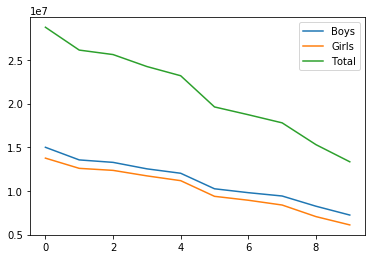

In [5]:
enrollment.plot()

The above graph shows the rapid decline in the number of students enrolled in schools as the grade progresses.
Let us examine this trend more closely

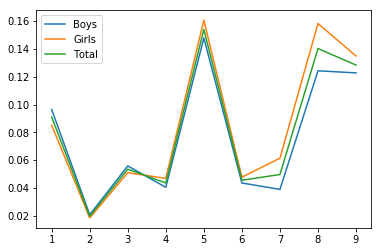

In [6]:
#let us compute the fraction of students that dropout in each grade
fraction_dropouts = enrollment.pct_change().dropna() * -1

fraction_dropouts.plot()

The dropout rates of girls and boys is almost same until the 6th grade, from there on a lot more girls start dropping out then boys, the difference although is of 2 to 3 %, it becomes significant when it is a 2 to 3 percent of a crore girls.

6th grade to 9th grade is usually the time when girls start menstruating, as they do, they drop out, this might be the explaination for this trend, let us verify this with some more analysis

#### Sanitation facilities in Indian schools

In [7]:
# This data is again available across 3 different excel sheets
facilities_primary = pd.read_excel('facilities_primary.xls')
facilities_secondary = pd.read_excel('facilities_secondary.xls')
facilities_u_primary = pd.read_excel('facilities_upper_primary.xls')

# Extracting and combining the information on urinals
schools_with_urinal = facilities_primary['Availability Within School Premises - Usable Urinal'] + facilities_secondary['Availability Within School Premises - Usable Urinal'] + facilities_u_primary['Availability Within School Premises - Usable Urinal']

# schools_with_urinal = pd.DataFrame(schools_with_urinal, index=facilities_primary['STATE/U.T.'])

schools_with_urinal.index = facilities_primary['STATE/U.T.']

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


The above data scources didn't provide us with the total number of schools in each state, so we will need to extract that information from a different file


In [8]:
school_category = pd.read_excel('school_category.xls')

# Subtracting the high school students (as we are only analysing trends til class 10)
total_schools = school_category['Total Schools\nof Schools'] - school_category['Higher Secondary Schools']
total_schools.index = school_category['STATE/U.T.']

# adding this information to a new dataframe
school_sanitation = pd.DataFrame()
school_sanitation['overall'] = total_schools
school_sanitation['with_toilets'] = schools_with_urinal

# computing the fraction of schools that have urinals
school_sanitation['fraction_with_toilets'] = school_sanitation['with_toilets']/school_sanitation['overall']

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [9]:
# fraction of girls retained from class 6th to 10th
girls_retained = all_grades['Enrolment in Class X - Girls']/all_grades['Enrolment in Class I - Girls']
girls_retained.index = all_grades['STATE/U.T.']

school_sanitation['girls_retained'] = girls_retained

In [10]:
girls_retained.corr(school_sanitation['fraction_with_toilets'])

0.48300662518507437

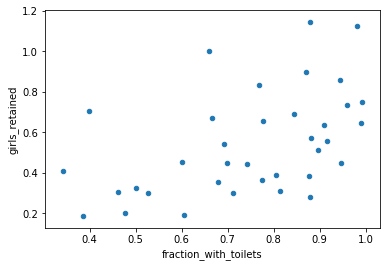

In [11]:
school_sanitation.plot.scatter('fraction_with_toilets','girls_retained')

With a correlation of ~0.5, the fraction of schools having toilets do give some estimate of the girls the schools are able to retain. But certainly there are some more factors that we need to dig in to.